# Modelo de Riesgo de Crédito

## Bibliotecas

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns

## Primer modelo

In [2]:
import os
df = pd.read_csv(os.path.join('..', 'data', 'output', 'loan_cleaned.csv'))

# Identificar las características y la variable objetivo
target = 'target'  
numerical_features = df.select_dtypes(include=['float', 'int']).columns
categorical_features = df.select_dtypes(include=['object']).columns 
numerical_features = numerical_features.drop('target')

X = df.drop(columns=[target])
y = df[target]

In [3]:
# Imputación de valores faltantes
numerical_imputer = SimpleImputer(strategy='median')
categorical_imputer = SimpleImputer(strategy='most_frequent')

# Preprocesamiento de variables categóricas y numéricas
categorical_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
numerical_scaler = StandardScaler()

# Pipeline para preprocesamiento
preprocessor = ColumnTransformer([
    ('num', Pipeline(steps=[
        ('imputer', numerical_imputer),
        ('scaler', numerical_scaler)
    ]), numerical_features),
    ('cat', Pipeline(steps=[
        ('imputer', categorical_imputer),
        ('encoder', categorical_encoder)
    ]), categorical_features)
])


In [4]:
# Dividir en conjuntos de entrenamiento, validación y prueba
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Aplicar el preprocesamiento
X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

In [5]:
# Definir el modelo
model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001),
			loss='binary_crossentropy',
			metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=50, 
                    batch_size=128, 
                    verbose=1)


Epoch 1/50
4190/4190 [==============================] - 9s 2ms/step - loss: 0.1194 - accuracy: 0.9703 - val_loss: 0.1058 - val_accuracy: 0.9736
Epoch 2/50
4190/4190 [==============================] - 7s 2ms/step - loss: 0.1089 - accuracy: 0.9731 - val_loss: 0.1045 - val_accuracy: 0.9740
Epoch 3/50
4190/4190 [==============================] - 7s 2ms/step - loss: 0.1077 - accuracy: 0.9732 - val_loss: 0.1047 - val_accuracy: 0.9739
Epoch 4/50
4190/4190 [==============================] - 7s 2ms/step - loss: 0.1069 - accuracy: 0.9733 - val_loss: 0.1034 - val_accuracy: 0.9740
Epoch 5/50
4190/4190 [==============================] - 7s 2ms/step - loss: 0.1065 - accuracy: 0.9734 - val_loss: 0.1040 - val_accuracy: 0.9740
Epoch 6/50
4190/4190 [==============================] - 7s 2ms/step - loss: 0.1060 - accuracy: 0.9734 - val_loss: 0.1035 - val_accuracy: 0.9741
Epoch 7/50
4190/4190 [==============================] - 7s 2ms/step - loss: 0.1058 - accuracy: 0.9734 - val_loss: 0.1034 - val_accuracy:

3592/3592 [==============================] - 2s 619us/step
AUC-ROC: 0.92


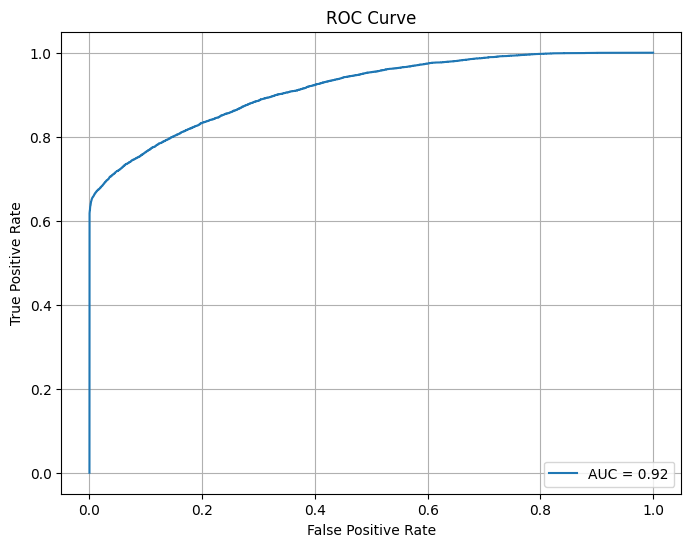

In [6]:
# Evaluar el modelo
y_pred_proba = model.predict(X_test).ravel()
auc_score = roc_auc_score(y_test, y_pred_proba)

print(f"AUC-ROC: {auc_score:.2f}")

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()


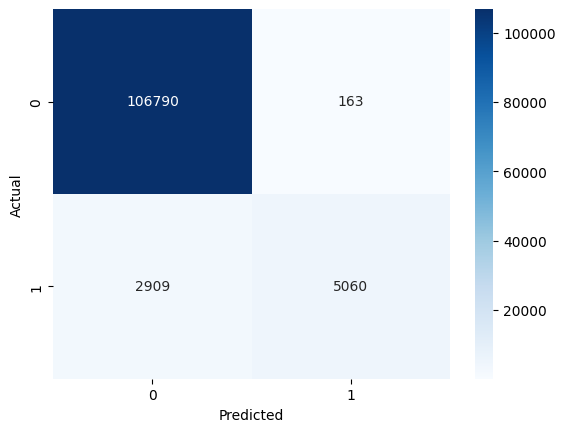

In [7]:
# Matriz de confusión
y_pred = (y_pred_proba > 0.5).astype(int)
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.show()

In [8]:
# Reporte de clasificación
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99    106953
           1       0.97      0.63      0.77      7969

    accuracy                           0.97    114922
   macro avg       0.97      0.82      0.88    114922
weighted avg       0.97      0.97      0.97    114922



In [9]:
# Función para convertir probabilidades a puntajes
def probability_to_score(prob, base_score=300, max_score=850, pdo=50):
    """
    Convierte probabilidades en puntajes de crédito dentro del rango [base_score, max_score].
    Args:
        prob (float): Probabilidad de default.
        base_score (int): Puntaje base (ej. 300).
        max_score (int): Puntaje máximo (ej. 850).
        pdo (int): Puntos para doblar las probabilidades (por defecto 50).
    Returns:
        score (float): Puntaje de crédito ajustado al rango.
    """
    odds = (1 - prob) / prob
    factor = pdo / np.log(2)
    offset = base_score + 200  # Ajustar el offset para centrar el rango en [300, 850]
    raw_score = offset - factor * np.log(odds)
    
    # Normalizar el score dentro del rango [300, 850]
    score = np.clip(raw_score, base_score, max_score)
    return score


# Convertir probabilidades a puntajes
y_scores = np.array([probability_to_score(p) for p in y_pred_proba])

C:\Users\alexg\AppData\Local\Temp\ipykernel_884\3888780631.py:16: RuntimeWarning: divide by zero encountered in log
  raw_score = offset - factor * np.log(odds)


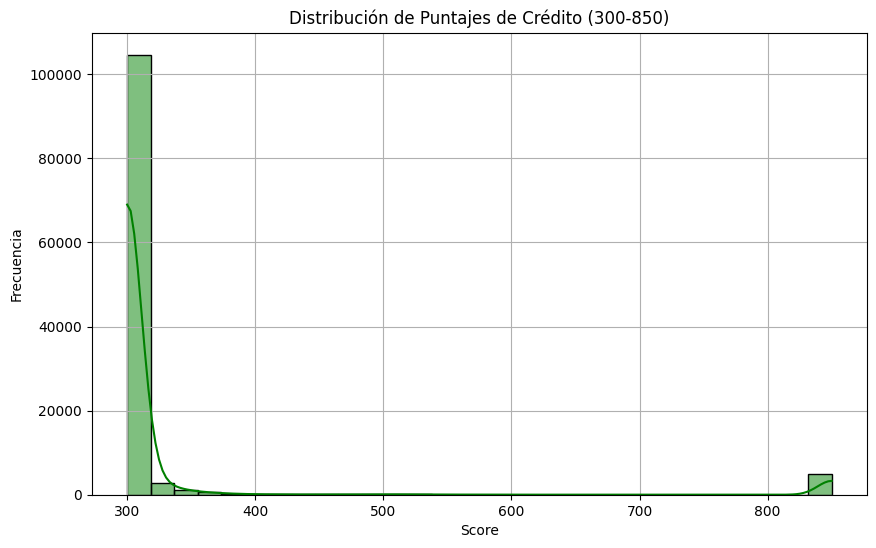

In [10]:
# Visualizar la distribución de los puntajes
plt.figure(figsize=(10, 6))
sns.histplot(y_scores, bins=30, kde=True, color='green')
plt.title("Distribución de Puntajes de Crédito (300-850)")
plt.xlabel("Score")
plt.ylabel("Frecuencia")
plt.grid()
plt.show()

In [11]:
import joblib
from tensorflow.keras.models import save_model

# Guardar el modelo entrenado
save_model(model, os.path.join('..', 'models', 'loan_model.h5'))

# Guardar el preprocesador
joblib.dump(preprocessor, os.path.join('..', 'models', 'preprocessor.pkl'))


C:\Users\alexg\AppData\Local\Temp\ipykernel_884\2176741268.py:5: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, os.path.join('..', 'models', 'loan_model.h5'))


['..\\models\\preprocessor.pkl']

## Segundo modelo

In [16]:
import os
df = pd.read_csv(os.path.join('..', 'data', 'output', 'loan_cleaned.csv'))

Se usan solo las características más relevantes, escogidas gracias a los análisis posteriores.

In [17]:
# Identificar las características y la variable objetivo
target = 'target'  
numerical_features = ['recoveries', 'collection_recovery_fee', 'total_rec_prncp', 'out_prncp', 'last_pymnt_amnt', 'total_pymnt', 'installment', 'funded_amnt_inv', 'loan_amnt', 'total_rec_int', 'total_rec_late_fee', 'int_rate', 'inq_last_6mths', 'open_acc']
categorical_features = df.select_dtypes(include=['object']).columns 

In [18]:
X = df[numerical_features + list(categorical_features)].drop(columns=[target], errors='ignore')
y = df[target]

In [19]:
# Imputación de valores faltantes
numerical_imputer = SimpleImputer(strategy='median')
categorical_imputer = SimpleImputer(strategy='most_frequent')

# Preprocesamiento de variables categóricas y numéricas
categorical_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
numerical_scaler = StandardScaler()

# Pipeline para preprocesamiento
preprocessor = ColumnTransformer([
    ('num', Pipeline(steps=[
        ('imputer', numerical_imputer),
        ('scaler', numerical_scaler)
    ]), numerical_features),
    ('cat', Pipeline(steps=[
        ('imputer', categorical_imputer),
        ('encoder', categorical_encoder)
    ]), categorical_features)
])


In [20]:
# Dividir en conjuntos de entrenamiento, validación y prueba
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Aplicar el preprocesamiento
X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Definir el modelo mejorado
model = Sequential([
    Dense(256, input_dim=X_train.shape[1], activation='relu'),  # Primera capa
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(128, activation='relu'),  # Segunda capa
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(64, activation='relu'),  # Tercera capa
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(32, activation='relu'),  # Cuarta capa
    Dropout(0.2),
    
    Dense(1, activation='sigmoid')  # Capa de salida
])

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0005),  # Aprendizaje más bajo
			loss='binary_crossentropy',
			metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=50,  # Más épocas para converger
                    batch_size=64,  # Menor tamaño de lote para un mejor ajuste
                    verbose=1)


Epoch 1/50
8380/8380 [==============================] - 22s 3ms/step - loss: 0.1346 - accuracy: 0.9651 - val_loss: 0.1050 - val_accuracy: 0.9737
Epoch 2/50
8380/8380 [==============================] - 20s 2ms/step - loss: 0.1120 - accuracy: 0.9725 - val_loss: 0.1038 - val_accuracy: 0.9741
Epoch 3/50
8380/8380 [==============================] - 20s 2ms/step - loss: 0.1097 - accuracy: 0.9729 - val_loss: 0.1044 - val_accuracy: 0.9740
Epoch 4/50
8380/8380 [==============================] - 21s 2ms/step - loss: 0.1087 - accuracy: 0.9729 - val_loss: 0.1040 - val_accuracy: 0.9740
Epoch 5/50
8380/8380 [==============================] - 21s 3ms/step - loss: 0.1080 - accuracy: 0.9729 - val_loss: 0.1042 - val_accuracy: 0.9739
Epoch 6/50
8380/8380 [==============================] - 20s 2ms/step - loss: 0.1072 - accuracy: 0.9731 - val_loss: 0.1031 - val_accuracy: 0.9741
Epoch 7/50
8380/8380 [==============================] - 20s 2ms/step - loss: 0.1070 - accuracy: 0.9730 - val_loss: 0.1040 - val_ac

3592/3592 [==============================] - 3s 772us/step
AUC-ROC: 0.92


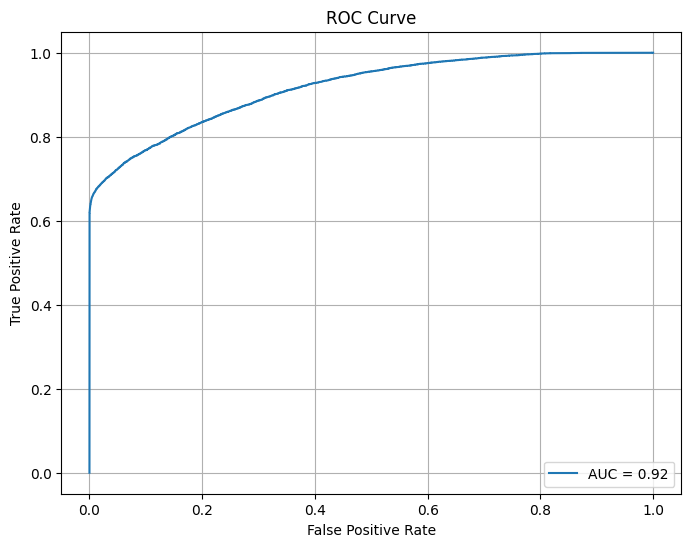

In [22]:
# Evaluar el modelo
y_pred_proba = model.predict(X_test).ravel()
auc_score = roc_auc_score(y_test, y_pred_proba)

print(f"AUC-ROC: {auc_score:.2f}")

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()


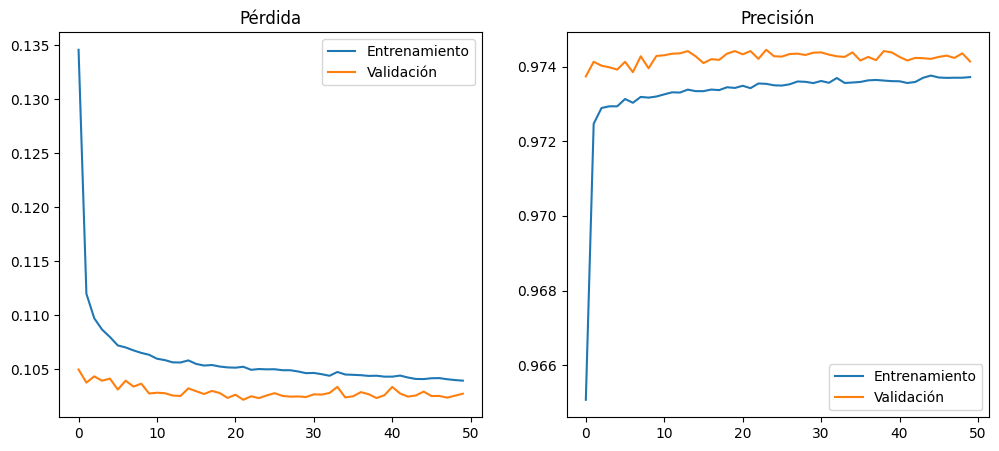

In [23]:
# Plot de la pérdida y accuracy
plt.figure(figsize=(12, 5))

# Pérdida
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión')
plt.legend()

plt.show()


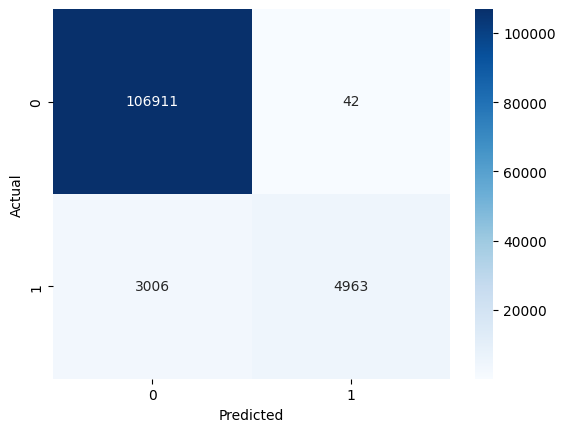

In [24]:
# Matriz de confusión
y_pred = (y_pred_proba > 0.5).astype(int)
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.show()

In [25]:
# Reporte de clasificación
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99    106953
           1       0.99      0.62      0.77      7969

    accuracy                           0.97    114922
   macro avg       0.98      0.81      0.88    114922
weighted avg       0.97      0.97      0.97    114922



In [26]:
# Función para convertir probabilidades a puntajes
def probability_to_score(prob, base_score=300, max_score=850, pdo=50):
    """
    Convierte probabilidades en puntajes de crédito dentro del rango [base_score, max_score].
    Args:
        prob (float): Probabilidad de default.
        base_score (int): Puntaje base (ej. 300).
        max_score (int): Puntaje máximo (ej. 850).
        pdo (int): Puntos para doblar las probabilidades (por defecto 50).
    Returns:
        score (float): Puntaje de crédito ajustado al rango.
    """
    odds = (1 - prob) / prob
    factor = pdo / np.log(2)
    offset = base_score + 200  # Ajustar el offset para centrar el rango en [300, 850]
    raw_score = offset - factor * np.log(odds)
    
    # Normalizar el score dentro del rango [300, 850]
    score = np.clip(raw_score, base_score, max_score)
    return score


# Convertir probabilidades a puntajes
y_scores = np.array([probability_to_score(p) for p in y_pred_proba])

C:\Users\alexg\AppData\Local\Temp\ipykernel_25692\3888780631.py:16: RuntimeWarning: divide by zero encountered in log
  raw_score = offset - factor * np.log(odds)


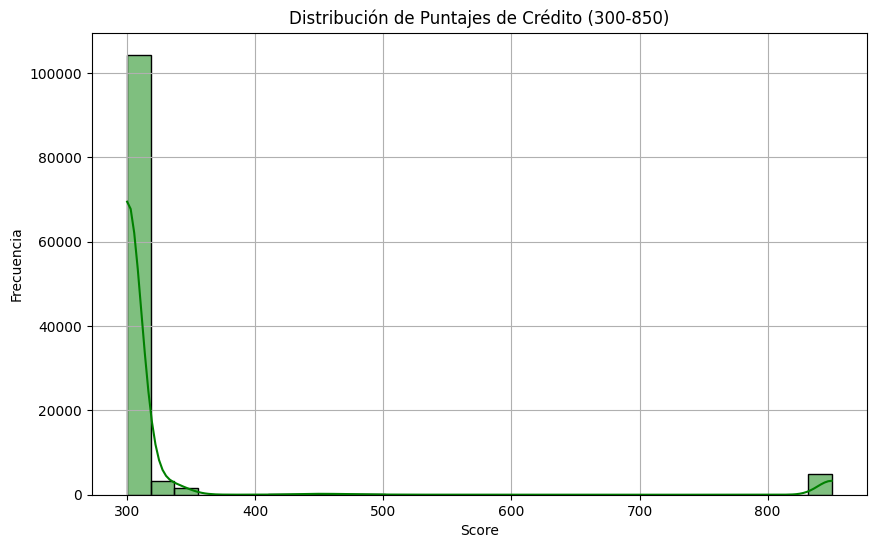

In [27]:
# Visualizar la distribución de los puntajes
plt.figure(figsize=(10, 6))
sns.histplot(y_scores, bins=30, kde=True, color='green')
plt.title("Distribución de Puntajes de Crédito (300-850)")
plt.xlabel("Score")
plt.ylabel("Frecuencia")
plt.grid()
plt.show()

In [39]:
import joblib
from tensorflow.keras.models import save_model

# Guardar el modelo entrenado
save_model(model, os.path.join('..', 'models', 'loan_model_2.h5'))
model.save(os.path.join('..', 'models', 'loan_model_2.h5'))
# Guardar el preprocesador
joblib.dump(preprocessor, os.path.join('..', 'models', 'preprocessor_2.pkl'))

C:\Users\alexg\AppData\Local\Temp\ipykernel_25692\1685099046.py:5: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, os.path.join('..', 'models', 'loan_model_2.h5'))
d:\PREGRADO INGENIERÍA DE SISTEMAS E INFORMÁTICA\2024-2. Redes Neuronales\trabajo_2\.venv\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


['..\\models\\preprocessor_2.pkl']

## Tercer modelo

In [2]:
import pandas as pd
import os
df = pd.read_csv(os.path.join('..', 'data', 'output', 'loan_cleaned.csv'))

Se usan solo las características más relevantes, escogidas gracias a los análisis posteriores y que además sean fáciles de conseguir por parte del cliente.

In [5]:
# Identificar las características y la variable objetivo
target = 'target'  
numerical_features = ['last_pymnt_amnt', 'total_pymnt', 'installment', 'funded_amnt_inv', 'loan_amnt', 'total_rec_int', 'int_rate', 'inq_last_6mths', 'open_acc']
categorical_features = ['term', 'emp_length', 'home_ownership', 'purpose']

In [6]:
X = df[numerical_features + list(categorical_features)].drop(columns=[target], errors='ignore')
y = df[target]

In [10]:
from sklearn.model_selection import train_test_split
# División inicial en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# División adicional para validación 
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)


In [13]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from imblearn.over_sampling import SMOTENC

# Imputación de valores faltantes
numerical_imputer = SimpleImputer(strategy='median')
categorical_imputer = SimpleImputer(strategy='most_frequent')

# Transformación logarítmica para numéricas relevantes
log_transformer = FunctionTransformer(func=np.log1p, validate=True)

# Preprocesamiento de variables categóricas y numéricas
categorical_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
numerical_scaler = StandardScaler()

# Pipeline para preprocesamiento
preprocessor = ColumnTransformer([
    ('num', Pipeline(steps=[
        ('imputer', numerical_imputer),
        ('log', log_transformer),  # Transformación logarítmica
        ('scaler', numerical_scaler)
    ]), numerical_features),
    ('cat', Pipeline(steps=[
        ('imputer', categorical_imputer),
        ('encoder', categorical_encoder)
    ]), categorical_features)
])

# Crear pipeline de preprocesamiento
pipeline_preprocess = Pipeline([
    ('preprocessor', preprocessor)
])

# Crear SMOTE
smote = SMOTENC(categorical_features=[X_train.columns.get_loc(col) for col in categorical_features], random_state=42)


In [14]:
# Aplicar preprocesamiento y balanceo
X_train_processed = pipeline_preprocess.fit_transform(X_train)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

# Procesar datos de validación
X_val_processed = pipeline_preprocess.transform(X_val)

# Procesar datos de prueba si existen
X_test_processed = pipeline_preprocess.transform(X_test)

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, BatchNormalization, MaxPooling1D
from tensorflow.keras.optimizers import Adam

# Modelo de red neuronal con convoluciones
def build_model(input_shape):
    model = Sequential([
        # Capa Conv1D: Detecta patrones locales
        Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),

        # Segunda capa Conv1D
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),

        # Aplanar las características
        Flatten(),

        # Capas densas
        Dense(128, activation='relu'),
        Dropout(0.3),
        BatchNormalization(),
        
        Dense(64, activation='relu'),
        Dropout(0.3),

        # Capa de salida (clasificación binaria)
        Dense(1, activation='sigmoid')
    ])
    
    # Compilar el modelo
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


In [17]:
# Reformatear datos para Conv1D
X_train_conv = X_train_resampled.reshape(X_train_resampled.shape[0], X_train_resampled.shape[1], 1)
X_val_conv = X_val_processed.reshape(X_val_processed.shape[0], X_val_processed.shape[1], 1)
X_test_conv = X_test_processed.reshape(X_test_processed.shape[0], X_test_processed.shape[1], 1)


In [18]:
# Crear el modelo
model = build_model(input_shape=(X_train_conv.shape[1], 1))

# Entrenar el modelo
history = model.fit(
    X_train_conv, y_train_resampled,
    validation_data=(X_val_conv, y_val),
    epochs=50,
    batch_size=128,
    verbose=1
)


Epoch 1/50
7131/7131 [==============================] - 40s 5ms/step - loss: 0.4456 - accuracy: 0.7767 - val_loss: 2.1810 - val_accuracy: 0.3910
Epoch 2/50
7131/7131 [==============================] - 40s 6ms/step - loss: 0.3975 - accuracy: 0.8028 - val_loss: 0.3800 - val_accuracy: 0.7912
Epoch 3/50
7131/7131 [==============================] - 41s 6ms/step - loss: 0.3766 - accuracy: 0.8122 - val_loss: 0.3785 - val_accuracy: 0.7928
Epoch 4/50
7131/7131 [==============================] - 40s 6ms/step - loss: 0.3640 - accuracy: 0.8181 - val_loss: 0.2370 - val_accuracy: 0.9147
Epoch 5/50
7131/7131 [==============================] - 40s 6ms/step - loss: 0.3559 - accuracy: 0.8223 - val_loss: 0.4906 - val_accuracy: 0.7175
Epoch 6/50
7131/7131 [==============================] - 40s 6ms/step - loss: 0.3508 - accuracy: 0.8254 - val_loss: 1.4657 - val_accuracy: 0.5132
Epoch 7/50
7131/7131 [==============================] - 43s 6ms/step - loss: 0.3464 - accuracy: 0.8277 - val_loss: 0.3194 - val_ac

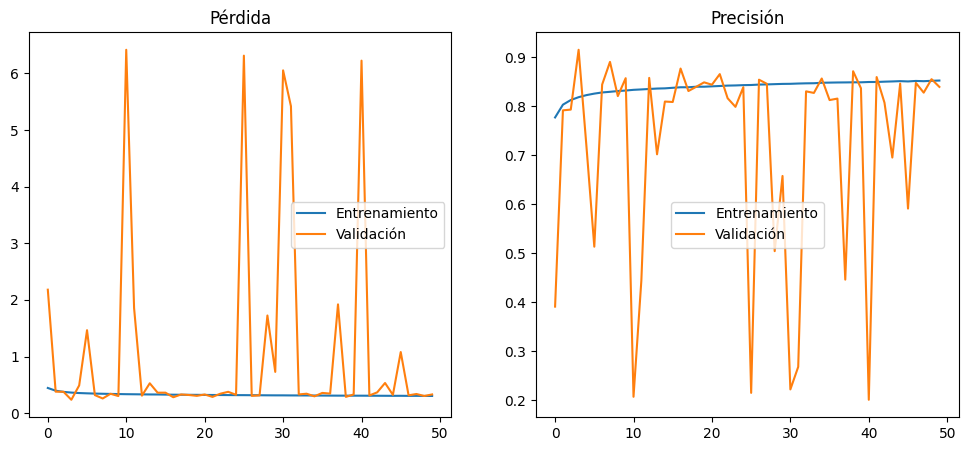

In [19]:
import matplotlib.pyplot as plt

# Plot de la pérdida y accuracy
plt.figure(figsize=(12, 5))

# Pérdida
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión')
plt.legend()

plt.show()


4789/4789 [==============================] - 6s 1ms/step
AUC-ROC: 0.82


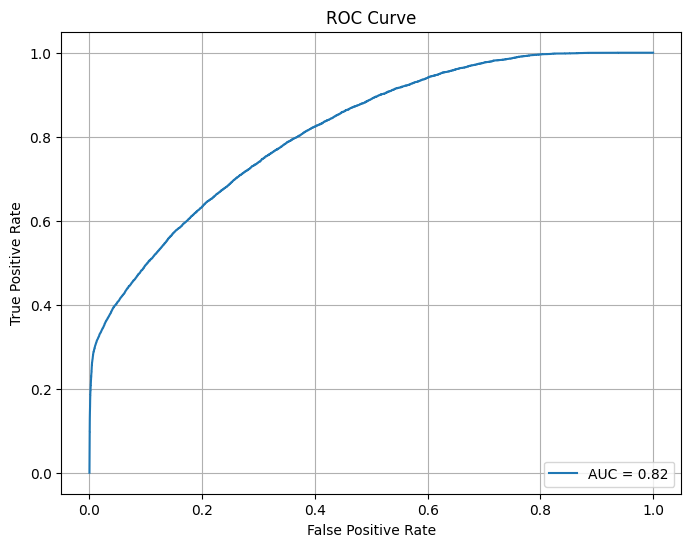

In [23]:
# Evaluar el modelo
y_pred_proba = model.predict(X_test_conv).ravel()
auc_score = roc_auc_score(y_test, y_pred_proba)

print(f"AUC-ROC: {auc_score:.2f}")

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()


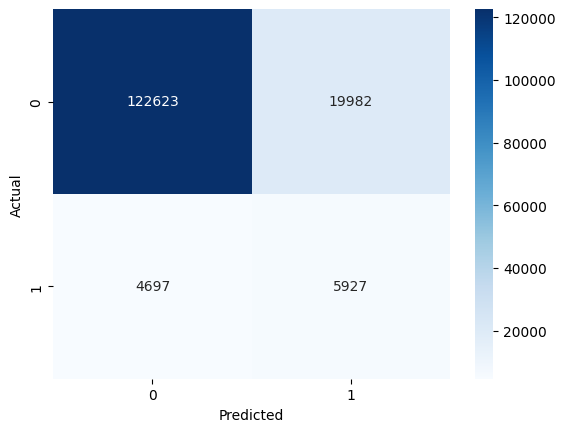

In [24]:
# Matriz de confusión
y_pred = (y_pred_proba > 0.5).astype(int)
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.show()

In [25]:
# Reporte de clasificación
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.86      0.91    142605
           1       0.23      0.56      0.32     10624

    accuracy                           0.84    153229
   macro avg       0.60      0.71      0.62    153229
weighted avg       0.91      0.84      0.87    153229



Usaremos una arquitectura más robusta para mejorar los resultados.

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, BatchNormalization, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Modelo de red neuronal con convoluciones
def build_model(input_shape):
    model = Sequential([
        # Capa Conv1D: Detecta patrones locales
        Conv1D(filters=32, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling1D(pool_size=3, strides=2),

        # Segunda capa Conv1D
        Conv1D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling1D(pool_size=3, strides=2),

        # Aplanar las características
        Flatten(),

        # Capas densas
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        BatchNormalization(),
        
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),

        # Capa de salida (clasificación binaria)
        Dense(1, activation='sigmoid')
    ])
    
    # Compilar el modelo
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


In [31]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

In [32]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

# Entrenamiento del modelo
history = model.fit(
    X_train_conv, y_train_resampled,
    validation_data=(X_val_conv, y_val),
    epochs=50,
    batch_size=128,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/50
7131/7131 [==============================] - 41s 6ms/step - loss: 0.4989 - accuracy: 0.7256 - val_loss: 1.0391 - val_accuracy: 0.5221 - lr: 0.0010
Epoch 2/50
7131/7131 [==============================] - 41s 6ms/step - loss: 0.4973 - accuracy: 0.7243 - val_loss: 13.7790 - val_accuracy: 0.1031 - lr: 0.0010
Epoch 3/50
7131/7131 [==============================] - 42s 6ms/step - loss: 0.4952 - accuracy: 0.7241 - val_loss: 1.8405 - val_accuracy: 0.3463 - lr: 0.0010
Epoch 4/50
7131/7131 [==============================] - 39s 5ms/step - loss: 0.4937 - accuracy: 0.7244 - val_loss: 1.0994 - val_accuracy: 0.5155 - lr: 0.0010
Epoch 5/50
7131/7131 [==============================] - 39s 6ms/step - loss: 0.4940 - accuracy: 0.7252 - val_loss: 1.1521 - val_accuracy: 0.4874 - lr: 0.0010
Epoch 6/50
7131/7131 [==============================] - 40s 6ms/step - loss: 0.4934 - accuracy: 0.7249 - val_loss: 1.0584 - val_accuracy: 0.5323 - lr: 0.0010
Epoch 7/50
7131/7131 [=============================

Este modelo no es lo suficientemente bueno.

In [ ]:
# Función para convertir probabilidades a puntajes
def probability_to_score(prob, base_score=300, max_score=850, pdo=50):
    """
    Convierte probabilidades en puntajes de crédito dentro del rango [base_score, max_score].
    Args:
        prob (float): Probabilidad de default.
        base_score (int): Puntaje base (ej. 300).
        max_score (int): Puntaje máximo (ej. 850).
        pdo (int): Puntos para doblar las probabilidades (por defecto 50).
    Returns:
        score (float): Puntaje de crédito ajustado al rango.
    """
    odds = (1 - prob) / prob
    factor = pdo / np.log(2)
    offset = base_score + 200  # Ajustar el offset para centrar el rango en [300, 850]
    raw_score = offset - factor * np.log(odds)
    
    # Normalizar el score dentro del rango [300, 850]
    score = np.clip(raw_score, base_score, max_score)
    return score


# Convertir probabilidades a puntajes
y_scores = np.array([probability_to_score(p) for p in y_pred_proba])

C:\Users\alexg\AppData\Local\Temp\ipykernel_884\3888780631.py:16: RuntimeWarning: divide by zero encountered in log
  raw_score = offset - factor * np.log(odds)


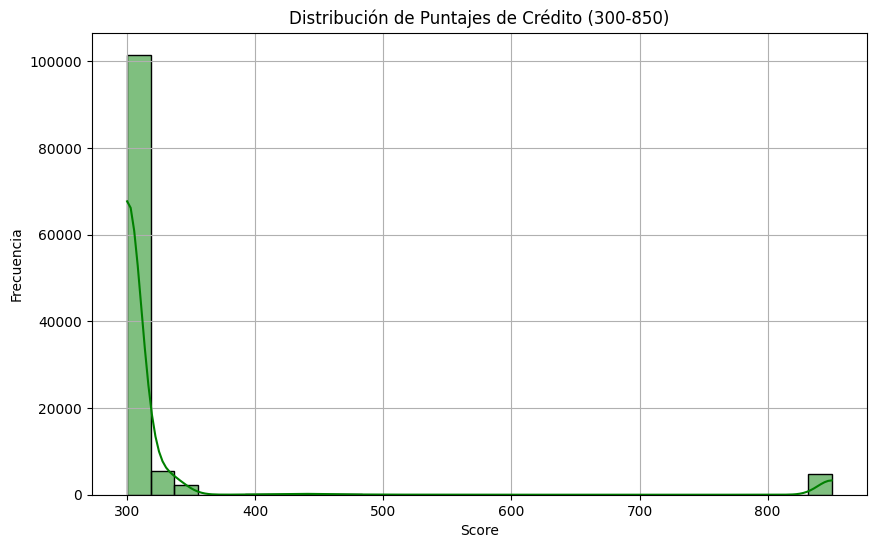

In [ ]:
# Visualizar la distribución de los puntajes
plt.figure(figsize=(10, 6))
sns.histplot(y_scores, bins=30, kde=True, color='green')
plt.title("Distribución de Puntajes de Crédito (300-850)")
plt.xlabel("Score")
plt.ylabel("Frecuencia")
plt.grid()
plt.show()

In [ ]:
import joblib
from tensorflow.keras.models import save_model
from tensorflow.keras.models import load_model

# Guardar el modelo entrenado
save_model(model, os.path.join('..', 'models', 'loan_model_3.h5'))

# Guardar el preprocesador
joblib.dump(preprocessor, os.path.join('..', 'models', 'preprocessor_3.pkl'))


C:\Users\alexg\AppData\Local\Temp\ipykernel_884\1741901262.py:5: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, os.path.join('..', 'models', 'loan_model_2.h5'))


['..\\models\\preprocessor_2.pkl']

In [ ]:
# Función para convertir probabilidades a puntajes
def probability_to_score(prob, base_score=300, max_score=850, pdo=50):
    """
    Convierte probabilidades en puntajes de crédito dentro del rango [base_score, max_score].
    Args:
        prob (float): Probabilidad de default.
        base_score (int): Puntaje base (ej. 300).
        max_score (int): Puntaje máximo (ej. 850).
        pdo (int): Puntos para doblar las probabilidades (por defecto 50).
    Returns:
        score (float): Puntaje de crédito ajustado al rango.
    """
    odds = (1 - prob) / prob
    factor = pdo / np.log(2)
    offset = base_score + 200  # Ajustar el offset para centrar el rango en [300, 850]
    raw_score = offset - factor * np.log(odds)
    
    # Normalizar el score dentro del rango [300, 850]
    score = np.clip(raw_score, base_score, max_score)
    return score


# Convertir probabilidades a puntajes
y_scores = np.array([probability_to_score(p) for p in y_pred_proba])

## Cuarto modelo

Usaremos la arquitectura del segundo modelo pero con los datos que acabamos de procesar en el tercer modelo

In [33]:
import pandas as pd
import os
df = pd.read_csv(os.path.join('..', 'data', 'output', 'loan_cleaned.csv'))

Se usan solo las características más relevantes, escogidas gracias a los análisis posteriores y que además sean fáciles de conseguir por parte del cliente.

In [34]:
# Identificar las características y la variable objetivo
target = 'target'  
numerical_features = ['last_pymnt_amnt', 'total_pymnt', 'installment', 'funded_amnt_inv', 'loan_amnt', 'total_rec_int', 'int_rate', 'inq_last_6mths', 'open_acc']
categorical_features = ['term', 'emp_length', 'home_ownership', 'purpose']

In [35]:
X = df[numerical_features + list(categorical_features)].drop(columns=[target], errors='ignore')
y = df[target]

In [36]:
from sklearn.model_selection import train_test_split
# División inicial en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# División adicional para validación 
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)


In [37]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from imblearn.over_sampling import SMOTENC

# Imputación de valores faltantes
numerical_imputer = SimpleImputer(strategy='median')
categorical_imputer = SimpleImputer(strategy='most_frequent')

# Transformación logarítmica para numéricas relevantes
log_transformer = FunctionTransformer(func=np.log1p, validate=True)

# Preprocesamiento de variables categóricas y numéricas
categorical_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
numerical_scaler = StandardScaler()

# Pipeline para preprocesamiento
preprocessor = ColumnTransformer([
    ('num', Pipeline(steps=[
        ('imputer', numerical_imputer),
        ('log', log_transformer),  # Transformación logarítmica
        ('scaler', numerical_scaler)
    ]), numerical_features),
    ('cat', Pipeline(steps=[
        ('imputer', categorical_imputer),
        ('encoder', categorical_encoder)
    ]), categorical_features)
])

# Crear pipeline de preprocesamiento
pipeline_preprocess = Pipeline([
    ('preprocessor', preprocessor)
])

# Crear SMOTE
smote = SMOTENC(categorical_features=[X_train.columns.get_loc(col) for col in categorical_features], random_state=42)


In [38]:
# Aplicar preprocesamiento y balanceo
X_train_processed = pipeline_preprocess.fit_transform(X_train)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

# Procesar datos de validación
X_val_processed = pipeline_preprocess.transform(X_val)

# Procesar datos de prueba si existen
X_test_processed = pipeline_preprocess.transform(X_test)

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Definir el modelo mejorado
model = Sequential([
    Dense(256, input_dim=X_train_resampled.shape[1], activation='relu'),  # Primera capa
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(128, activation='relu'),  # Segunda capa
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(64, activation='relu'),  # Tercera capa
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(32, activation='relu'),  # Cuarta capa
    Dropout(0.2),
    
    Dense(1, activation='sigmoid')  # Capa de salida
])

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0005),  # Aprendizaje más bajo
			loss='binary_crossentropy',
			metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train_resampled, y_train_resampled, 
                    validation_data=(X_val_processed, y_val), 
                    epochs=50,  # Más épocas para converger
                    batch_size=64,  # Menor tamaño de lote para un mejor ajuste
                    verbose=1)


Epoch 1/50
14261/14261 [==============================] - 38s 3ms/step - loss: 0.4734 - accuracy: 0.7596 - val_loss: 0.3980 - val_accuracy: 0.7805
Epoch 2/50
14261/14261 [==============================] - 38s 3ms/step - loss: 0.4046 - accuracy: 0.7959 - val_loss: 0.3660 - val_accuracy: 0.8213
Epoch 3/50
14261/14261 [==============================] - 38s 3ms/step - loss: 0.3910 - accuracy: 0.8025 - val_loss: 0.3592 - val_accuracy: 0.8342
Epoch 4/50
14261/14261 [==============================] - 37s 3ms/step - loss: 0.3840 - accuracy: 0.8064 - val_loss: 0.3478 - val_accuracy: 0.8331
Epoch 5/50
14261/14261 [==============================] - 38s 3ms/step - loss: 0.3780 - accuracy: 0.8100 - val_loss: 0.3813 - val_accuracy: 0.8278
Epoch 6/50
14261/14261 [==============================] - 39s 3ms/step - loss: 0.3736 - accuracy: 0.8120 - val_loss: 0.3616 - val_accuracy: 0.8242
Epoch 7/50
14261/14261 [==============================] - 36s 3ms/step - loss: 0.3699 - accuracy: 0.8140 - val_loss: 0

4789/4789 [==============================] - 4s 785us/step
AUC-ROC: 0.82


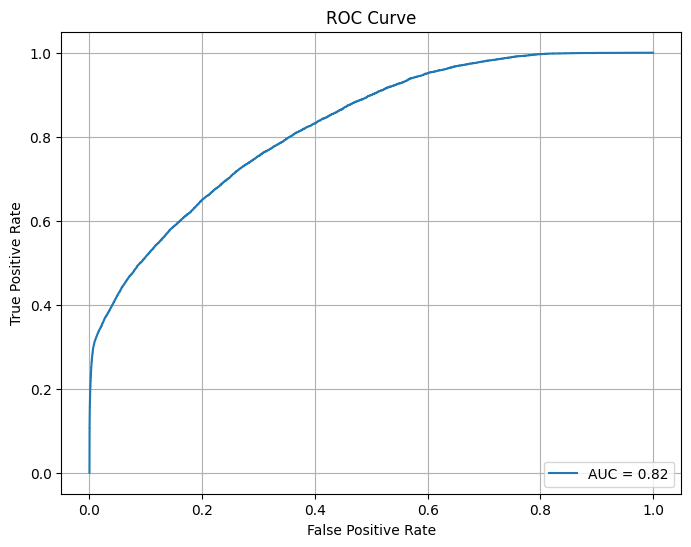

In [48]:
# Evaluar el modelo
y_pred_proba = model.predict(X_test_processed).ravel()
auc_score = roc_auc_score(y_test, y_pred_proba)

print(f"AUC-ROC: {auc_score:.2f}")

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()


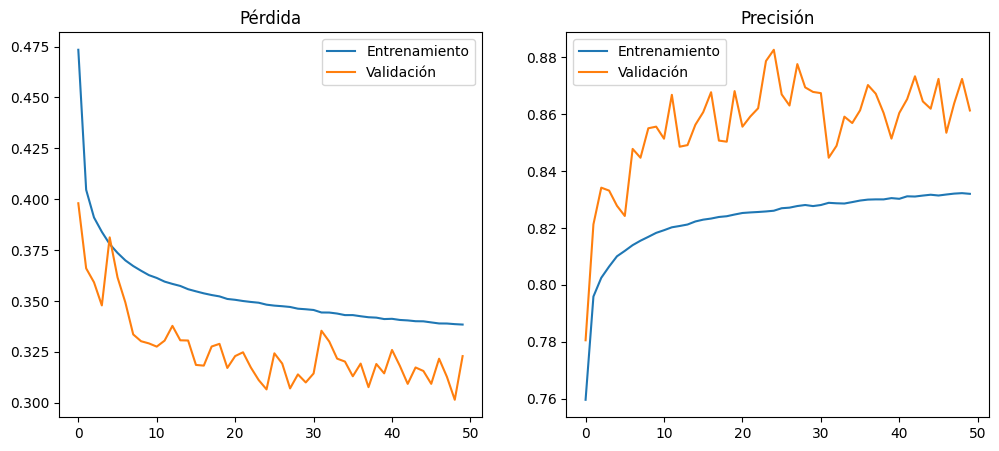

In [49]:
# Plot de la pérdida y accuracy
plt.figure(figsize=(12, 5))

# Pérdida
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión')
plt.legend()

plt.show()


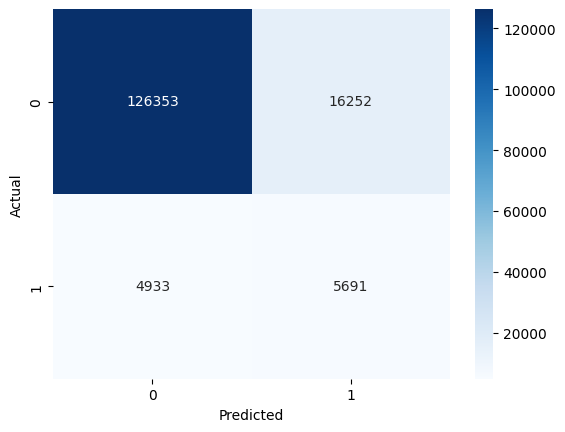

In [50]:
# Matriz de confusión
y_pred = (y_pred_proba > 0.5).astype(int)
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.show()

In [51]:
# Reporte de clasificación
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.89      0.92    142605
           1       0.26      0.54      0.35     10624

    accuracy                           0.86    153229
   macro avg       0.61      0.71      0.64    153229
weighted avg       0.91      0.86      0.88    153229



In [52]:
# Función para convertir probabilidades a puntajes
def probability_to_score(prob, base_score=300, max_score=850, pdo=50):
    """
    Convierte probabilidades en puntajes de crédito dentro del rango [base_score, max_score].
    Args:
        prob (float): Probabilidad de default.
        base_score (int): Puntaje base (ej. 300).
        max_score (int): Puntaje máximo (ej. 850).
        pdo (int): Puntos para doblar las probabilidades (por defecto 50).
    Returns:
        score (float): Puntaje de crédito ajustado al rango.
    """
    odds = (1 - prob) / prob
    factor = pdo / np.log(2)
    offset = base_score + 200  # Ajustar el offset para centrar el rango en [300, 850]
    raw_score = offset - factor * np.log(odds)
    
    # Normalizar el score dentro del rango [300, 850]
    score = np.clip(raw_score, base_score, max_score)
    return score


# Convertir probabilidades a puntajes
y_scores = np.array([probability_to_score(p) for p in y_pred_proba])

C:\Users\alexg\AppData\Local\Temp\ipykernel_12052\3888780631.py:16: RuntimeWarning: divide by zero encountered in log
  raw_score = offset - factor * np.log(odds)


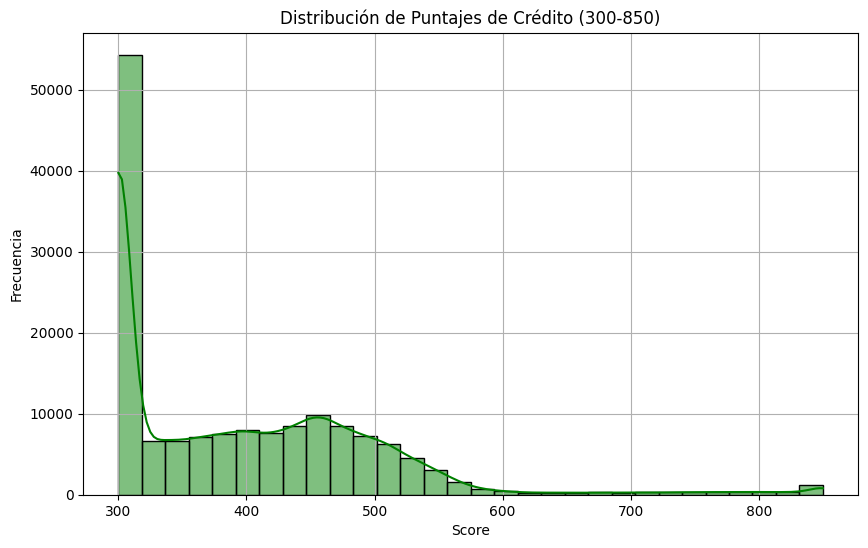

In [53]:
# Visualizar la distribución de los puntajes
plt.figure(figsize=(10, 6))
sns.histplot(y_scores, bins=30, kde=True, color='green')
plt.title("Distribución de Puntajes de Crédito (300-850)")
plt.xlabel("Score")
plt.ylabel("Frecuencia")
plt.grid()
plt.show()

In [54]:
import joblib
from tensorflow.keras.models import save_model

# Guardar el modelo entrenado
save_model(model, os.path.join('..', 'models', 'loan_model_4.h5'))

# Guardar el preprocesador
joblib.dump(preprocessor, os.path.join('..', 'models', 'preprocessor_4.pkl'))

C:\Users\alexg\AppData\Local\Temp\ipykernel_12052\1285342125.py:5: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, os.path.join('..', 'models', 'loan_model_4.h5'))


['..\\models\\preprocessor_4.pkl']

## Quinto modelo

Ya que usar técnicas de rebalanceo de datos y manejo de outliers no mejora el desempeño del modelo, se volverá a usar el conjunto de datos sin estos procesamientos; se usará también la arquitectura del segundo modelo, pero seleccionando las variables más relevantes y fáciles de conseguir

In [1]:
import pandas as pd
import os
df = pd.read_csv(os.path.join('..', 'data', 'output', 'loan_cleaned.csv'))

In [2]:
# Identificar las características y la variable objetivo
target = 'target'  
numerical_features = ['last_pymnt_amnt', 'total_pymnt', 'installment', 'funded_amnt_inv', 'loan_amnt', 'total_rec_int', 'int_rate', 'inq_last_6mths', 'open_acc']
categorical_features = ['term', 'emp_length', 'home_ownership', 'purpose']

In [3]:
X = df[numerical_features + list(categorical_features)].drop(columns=[target], errors='ignore')
y = df[target]

In [6]:
# Imputación de valores faltantes
numerical_imputer = SimpleImputer(strategy='median')
categorical_imputer = SimpleImputer(strategy='most_frequent')

# Preprocesamiento de variables categóricas y numéricas
categorical_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
numerical_scaler = StandardScaler()

# Pipeline para preprocesamiento
preprocessor = ColumnTransformer([
    ('num', Pipeline(steps=[
        ('imputer', numerical_imputer),
        ('scaler', numerical_scaler)
    ]), numerical_features),
    ('cat', Pipeline(steps=[
        ('imputer', categorical_imputer),
        ('encoder', categorical_encoder)
    ]), categorical_features)
])


In [7]:
# Dividir en conjuntos de entrenamiento, validación y prueba
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Aplicar el preprocesamiento
X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Definir el modelo mejorado
model = Sequential([
    Dense(256, input_dim=X_train.shape[1], activation='relu'),  # Primera capa
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(128, activation='relu'),  # Segunda capa
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(64, activation='relu'),  # Tercera capa
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(32, activation='relu'),  # Cuarta capa
    Dropout(0.2),
    
    Dense(1, activation='sigmoid')  # Capa de salida
])

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0005),  # Aprendizaje más bajo
			loss='binary_crossentropy',
			metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=50,  # Más épocas para converger
                    batch_size=64,  # Menor tamaño de lote para un mejor ajuste
                    verbose=1)


Epoch 1/50
8380/8380 [==============================] - 23s 3ms/step - loss: 0.2364 - accuracy: 0.9260 - val_loss: 0.2098 - val_accuracy: 0.9307
Epoch 2/50
8380/8380 [==============================] - 23s 3ms/step - loss: 0.2106 - accuracy: 0.9340 - val_loss: 0.1962 - val_accuracy: 0.9389
Epoch 3/50
8380/8380 [==============================] - 22s 3ms/step - loss: 0.2022 - accuracy: 0.9378 - val_loss: 0.1922 - val_accuracy: 0.9405
Epoch 4/50
8380/8380 [==============================] - 22s 3ms/step - loss: 0.1991 - accuracy: 0.9387 - val_loss: 0.1907 - val_accuracy: 0.9411
Epoch 5/50
8380/8380 [==============================] - 23s 3ms/step - loss: 0.1979 - accuracy: 0.9392 - val_loss: 0.1904 - val_accuracy: 0.9410
Epoch 6/50
8380/8380 [==============================] - 21s 2ms/step - loss: 0.1963 - accuracy: 0.9398 - val_loss: 0.1910 - val_accuracy: 0.9407
Epoch 7/50
8380/8380 [==============================] - 21s 2ms/step - loss: 0.1955 - accuracy: 0.9402 - val_loss: 0.1891 - val_ac

3592/3592 [==============================] - 4s 1ms/step
AUC-ROC: 0.84


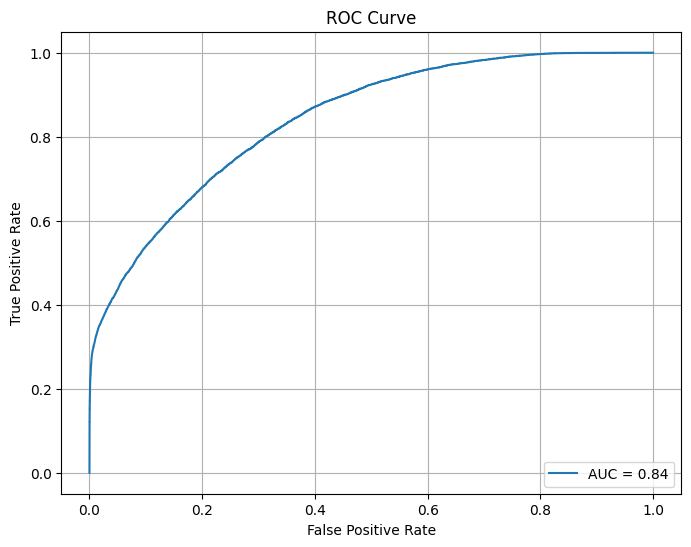

In [9]:
# Evaluar el modelo
y_pred_proba = model.predict(X_test).ravel()
auc_score = roc_auc_score(y_test, y_pred_proba)

print(f"AUC-ROC: {auc_score:.2f}")

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()


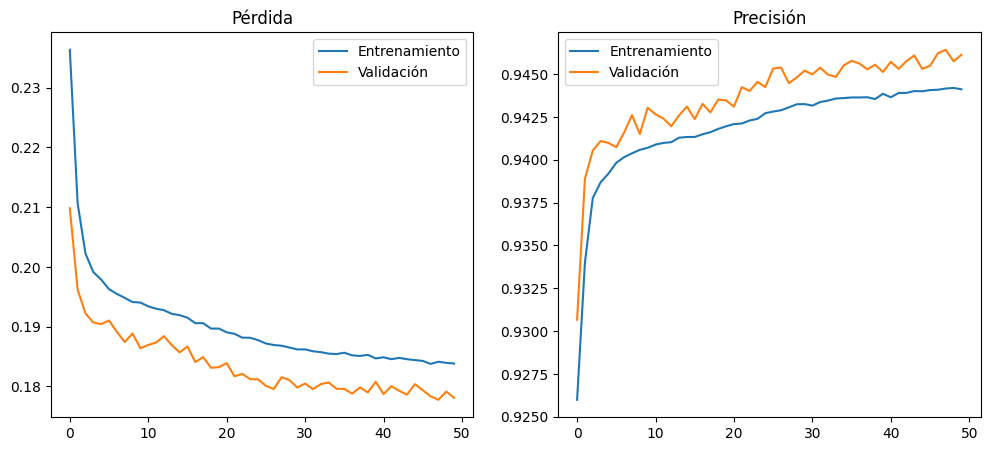

In [10]:
# Plot de la pérdida y accuracy
plt.figure(figsize=(12, 5))

# Pérdida
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión')
plt.legend()

plt.show()


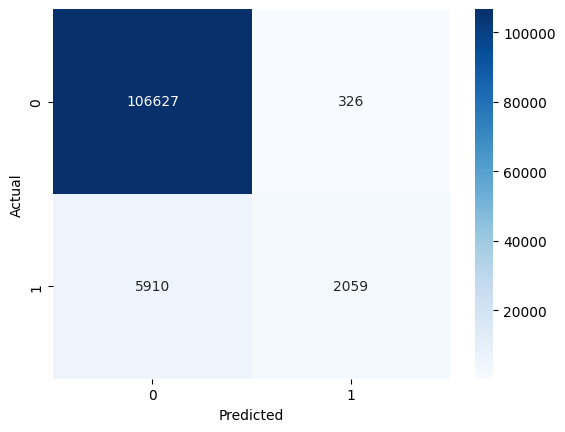

In [11]:
# Matriz de confusión
y_pred = (y_pred_proba > 0.5).astype(int)
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.show()

In [12]:
# Reporte de clasificación
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97    106953
           1       0.86      0.26      0.40      7969

    accuracy                           0.95    114922
   macro avg       0.91      0.63      0.68    114922
weighted avg       0.94      0.95      0.93    114922



In [13]:
# Función para convertir probabilidades a puntajes
def probability_to_score(prob, base_score=300, max_score=850, pdo=50):
    """
    Convierte probabilidades en puntajes de crédito dentro del rango [base_score, max_score].
    Args:
        prob (float): Probabilidad de default.
        base_score (int): Puntaje base (ej. 300).
        max_score (int): Puntaje máximo (ej. 850).
        pdo (int): Puntos para doblar las probabilidades (por defecto 50).
    Returns:
        score (float): Puntaje de crédito ajustado al rango.
    """
    odds = (1 - prob) / prob
    factor = pdo / np.log(2)
    offset = base_score + 200  # Ajustar el offset para centrar el rango en [300, 850]
    raw_score = offset - factor * np.log(odds)
    
    # Normalizar el score dentro del rango [300, 850]
    score = np.clip(raw_score, base_score, max_score)
    return score


# Convertir probabilidades a puntajes
y_scores = np.array([probability_to_score(p) for p in y_pred_proba])

C:\Users\alexg\AppData\Local\Temp\ipykernel_25692\3888780631.py:16: RuntimeWarning: divide by zero encountered in log
  raw_score = offset - factor * np.log(odds)


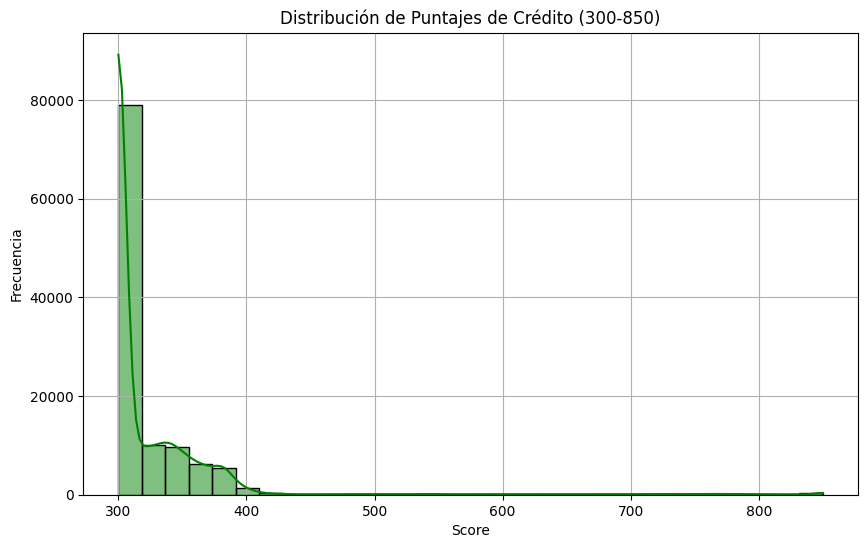

In [14]:
# Visualizar la distribución de los puntajes
plt.figure(figsize=(10, 6))
sns.histplot(y_scores, bins=30, kde=True, color='green')
plt.title("Distribución de Puntajes de Crédito (300-850)")
plt.xlabel("Score")
plt.ylabel("Frecuencia")
plt.grid()
plt.show()

In [15]:
import joblib
from tensorflow.keras.models import save_model

# Guardar el modelo entrenado
save_model(model, os.path.join('..', 'models', 'loan_model_5.h5'))

# Guardar el preprocesador
joblib.dump(preprocessor, os.path.join('..', 'models', 'preprocessor_5.pkl'))

C:\Users\alexg\AppData\Local\Temp\ipykernel_25692\2816248437.py:5: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, os.path.join('..', 'models', 'loan_model_5.h5'))


['..\\models\\preprocessor_5.pkl']

Se evidencia un gran retroceso en el F1-Score, por lo que se concluye que el mejor modelo es el segundo modelo

## Distribución del score

In [30]:
import os
df = pd.read_csv(os.path.join('..', 'data', 'output', 'loan_cleaned.csv'))

In [31]:
# Identificar las características y la variable objetivo
target = 'target'  
numerical_features = ['recoveries', 'collection_recovery_fee', 'total_rec_prncp', 'out_prncp', 'last_pymnt_amnt', 'total_pymnt', 'installment', 'funded_amnt_inv', 'loan_amnt', 'total_rec_int', 'total_rec_late_fee', 'int_rate', 'inq_last_6mths', 'open_acc']
categorical_features = df.select_dtypes(include=['object']).columns 

In [32]:
X = df[numerical_features + list(categorical_features)].drop(columns=[target], errors='ignore')
y = df[target]

In [43]:
# Cargar el modelo y preprocesador
from tensorflow.keras.models import load_model
from pathlib import Path
import os

# Obtener ruta absoluta y normalizada
model_path = Path(os.path.abspath(os.path.join('..', 'models', 'loan_model_2.h5')))

# Cargar el modelo usando str() para convertir Path a string
model = load_model(str(model_path))

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xcd in position 24: invalid continuation byte

In [46]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 256)               14592     
                                                                 
 batch_normalization_3 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_4 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_5 (Dropout)         (None, 128)              

In [38]:
preprocessor = joblib.load(os.path.join('..', 'models', 'preprocessor_2.pkl'))

In [47]:
# Aplicar el preprocesamiento
X = preprocessor.transform(X)

In [48]:
# Realizar predicciones
y_pred_proba = model.predict(X).ravel()

23942/23942 [==============================] - 19s 783us/step


In [49]:
y_pred = (y_pred_proba > 0.5).astype(int)

In [50]:
# Función para convertir probabilidades a puntajes
def probability_to_score(prob, base_score=300, max_score=850, pdo=50):
    """
    Convierte probabilidades en puntajes de crédito dentro del rango [base_score, max_score].
    Args:
        prob (float): Probabilidad de default.
        base_score (int): Puntaje base (ej. 300).
        max_score (int): Puntaje máximo (ej. 850).
        pdo (int): Puntos para doblar las probabilidades (por defecto 50).
    Returns:
        score (float): Puntaje de crédito ajustado al rango.
    """
    odds = (1 - prob) / prob
    factor = pdo / np.log(2)
    offset = base_score + 200  # Ajustar el offset para centrar el rango en [300, 850]
    raw_score = offset - factor * np.log(odds)
    
    # Normalizar el score dentro del rango [300, 850]
    score = np.clip(raw_score, base_score, max_score)
    return score

In [56]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [57]:
y_pred_proba

array([0.0154998 , 0.04893586, 0.0070049 , ..., 0.05046559, 0.08810192,
       0.040065  ], dtype=float32)

In [51]:
# Convertir probabilidades a puntajes
y_scores = np.array([probability_to_score(p) for p in y_pred_proba])

C:\Users\alexg\AppData\Local\Temp\ipykernel_25692\3972505839.py:16: RuntimeWarning: divide by zero encountered in log
  raw_score = offset - factor * np.log(odds)


In [53]:
y_scores

array([300.        , 300.        , 300.        , ..., 300.        ,
       331.41863529, 300.        ])

In [58]:
joblib.dump(y_scores, os.path.join('..', 'data', 'output', 'loan_scores.pkl'))

['..\\data\\output\\loan_scores.pkl']

In [59]:
y_scores = joblib.load(os.path.join('..', 'data', 'output', 'loan_scores.pkl'))

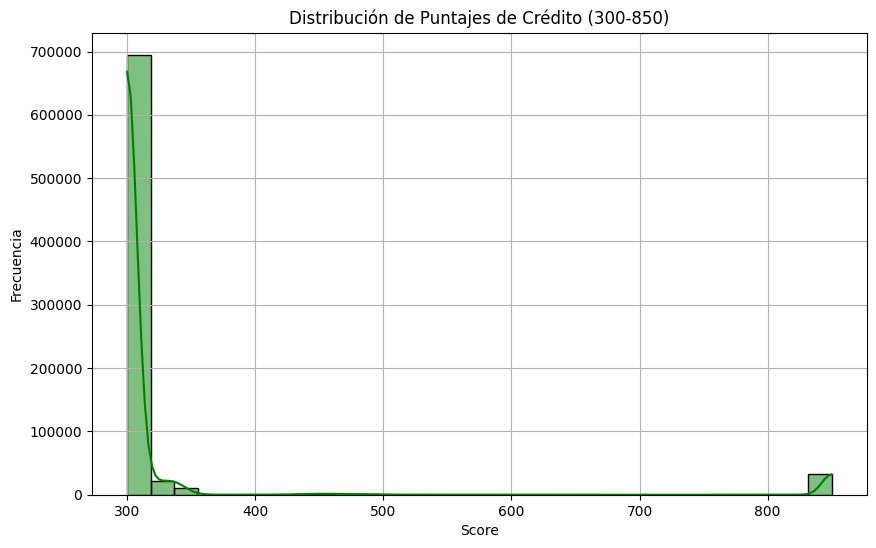

In [60]:
# Visualizar la distribución de los puntajes
plt.figure(figsize=(10, 6))
sns.histplot(y_scores, bins=30, kde=True, color='green')
plt.title("Distribución de Puntajes de Crédito (300-850)")
plt.xlabel("Score")
plt.ylabel("Frecuencia")
plt.grid()
plt.show()

In [61]:
test_point = 400

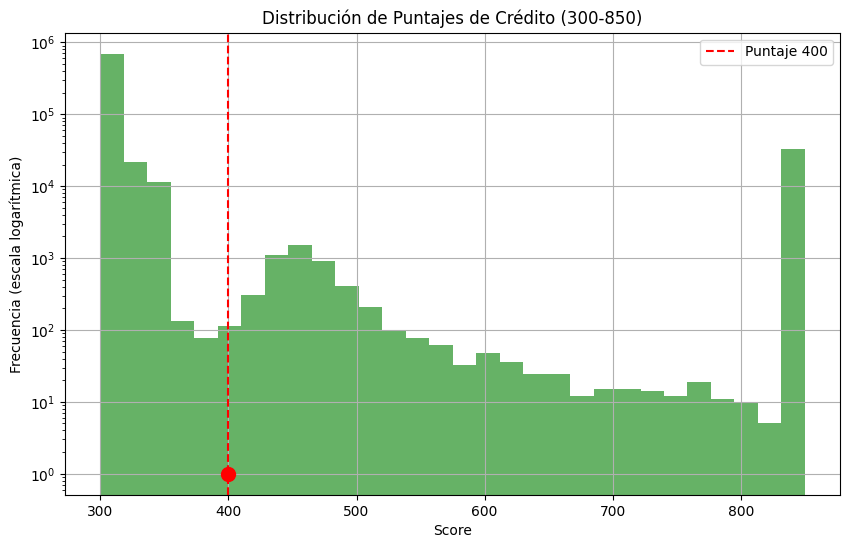

In [ ]:
# Visualizar la distribución de los puntajes con escala logarítmica
plt.figure(figsize=(10, 6))
plt.hist(y_scores, bins=30, color='green', alpha=0.6)
plt.yscale('log')
plt.axvline(x=test_point, color='red', linestyle='--', label=f'Puntaje {test_point}')
plt.scatter(test_point, 1, color='red', s=100, zorder=5)
plt.title("Distribución de Puntajes de Crédito (300-850)")
plt.xlabel("Score")
plt.ylabel("Frecuencia (escala logarítmica)")
plt.grid(True)
plt.legend()
plt.show()


In [78]:
def plot_credit_score_distribution(scores, point):
	plt.figure(figsize=(10, 6))
	plt.hist(scores, bins=30, color='green', alpha=0.6)
	plt.yscale('log')
	plt.axvline(x=point, color='red', linestyle='--', label=f'Puntaje {point}')
	plt.scatter(point, 1, color='red', s=100, zorder=5)
	plt.title("Distribución de Puntajes de Crédito (300-850)")
	plt.xlabel("Puntaje")
	plt.ylabel("Frecuencia (escala logarítmica)")
	plt.grid(True)
	plt.legend()
	plt.show()

In [ ]:
plot_credit_score_distribution(y_scores, 800)